# Speech Emotion Recognition

## Dataset: [RAVDESS](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)

### Extracting the data

In [1]:
import os

DATA_DIR = "dataset/"

files = []
for filename in os.listdir(DATA_DIR):
    for audio_file in os.listdir(DATA_DIR + filename):
        files.append(filename + "/" + audio_file)

print(len(files))


1440


In [2]:
# extracting the class labels i.e the emotion
labels = []
for filename in files:
    emotion = filename.split('/')[1].split('.')[0].split('-')[2]
    labels.append(emotion)

print(len(labels))

1440


In [3]:
class_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
new_labels = [class_map[label] for label in labels]

In [5]:
import pandas as pd

dataframe = dict(zip(files, new_labels))
df = pd.DataFrame(list(dataframe.items()), columns=['filename', 'emotion'])
df.head()


,filename,emotion
0,Actor_05/03-01-07-02-02-01-05.wav,disgust
1,Actor_05/03-01-05-02-01-01-05.wav,angry
2,Actor_05/03-01-04-02-02-02-05.wav,sad
3,Actor_05/03-01-04-01-02-01-05.wav,sad
4,Actor_05/03-01-06-02-01-01-05.wav,fearful


In [6]:
df.to_csv('dataset.csv', index=False)

### Exploratory Data Analysis

In [7]:
df['emotion'].value_counts()

emotion
disgust      192
angry        192
sad          192
fearful      192
surprised    192
calm         192
happy        192
neutral       96
Name: count, dtype: int64

It is a fairly balanced dataset

There are two statements spoken by the voice actors: "Kids are talking by the door" and "Dogs are sitting by the door"

In [8]:
for i in range(0, len(df)):
    filename = df.loc[i, 'filename']
    line_spoken = filename.split('/')[1].split('.')[0].split('-')[4]
    df.loc[i, 'line'] = line_spoken
    

In [9]:
df['line'].value_counts()

line
02    720
01    720
Name: count, dtype: int64

Both lines spoken equally even among the different emotions

In [10]:
df.groupby(['emotion', 'line']).size()

emotion    line
angry      01      96
           02      96
calm       01      96
           02      96
disgust    01      96
           02      96
fearful    01      96
           02      96
happy      01      96
           02      96
neutral    01      48
           02      48
sad        01      96
           02      96
surprised  01      96
           02      96
dtype: int64

Emotional Intensity:

In [11]:
for i in range(0, len(df)):
    filename = df.loc[i, 'filename']
    intensity = filename.split('/')[1].split('.')[0].split('-')[3]
    df.loc[i, 'intensity'] = intensity
    

In [12]:
df['intensity'].value_counts()

intensity
01    768
02    672
Name: count, dtype: int64

Fairly balanced in this aspect as well

But we are not using the type of line or the emotional intensity for classification, so we may ignore these columns.

In [13]:
df.drop(columns=['intensity', 'line'], inplace=True)

## Audio Visualisation

In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random

In [15]:
def waveplot(path_to_audio, emotion):
    plt.figure(figsize=(10, 3))
    data, sampling_rate = librosa.load(path_to_audio)
    plt.title(emotion)
    librosa.display.waveshow(data, sr=sampling_rate, color="blue")

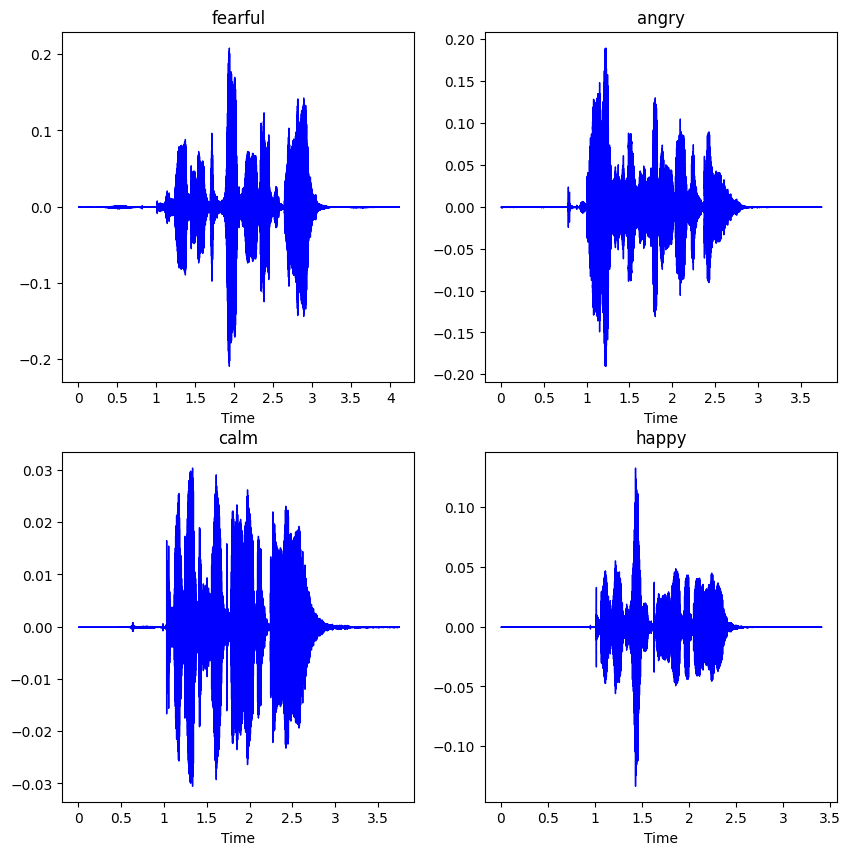

In [16]:

# plot  4 waveplots in a grid
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    index = random.randint(0, len(df))
    data, sampling_rate = librosa.load(DATA_DIR + df.loc[index, 'filename'])
    plt.title(df.loc[index, 'emotion'])
    librosa.display.waveshow(data, sr=sampling_rate, color="blue")

## Feature Extraction

1. Mel-Frequency Ceptral Coefficients (MFCC)
2. Mel-spectrogram
3. Short-time Fourier Transform (STFT)
4. Spectral Centroid, Spectral Bandwidth

## MFCCs

In [17]:
path = df.loc[0, 'filename']
path

'Actor_05/03-01-07-02-02-01-05.wav'

In [18]:
# loading an example audio file
data, sampling_rate = librosa.load(DATA_DIR + df.loc[10, 'filename'], sr=22050*2, duration=5, offset=0.5)

# calculating mfcc of the audio file
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)

In [19]:
import IPython.display as ipd  

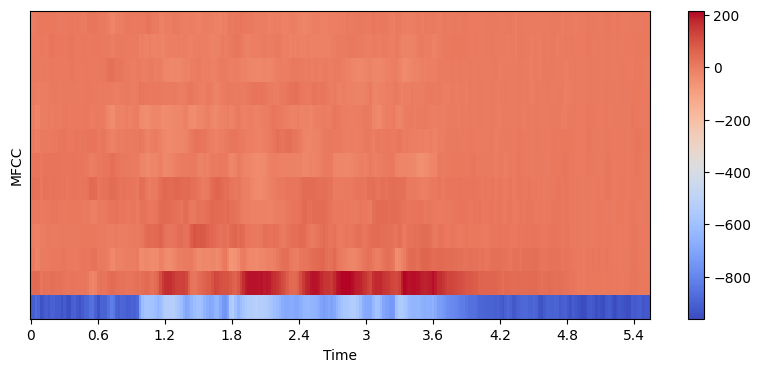

In [20]:
# plotting the mfcc
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.ylabel('MFCC')

ipd.Audio(DATA_DIR + df.loc[0, 'filename'])


216


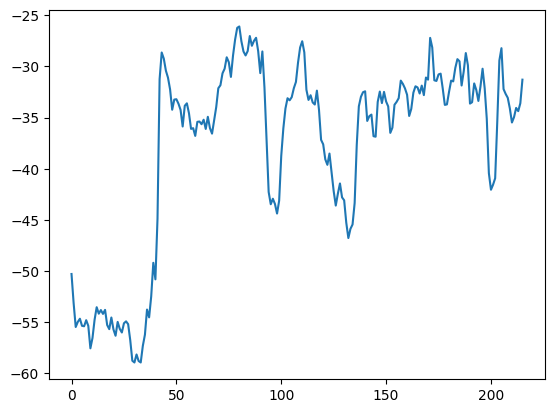

In [21]:
# taking the mean of mfccs
data, sampling_rate = librosa.load(DATA_DIR + df.loc[0, 'filename'], sr=22050*2, duration=2.5, offset=0.5)
mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
print(len(mfccs))
plt.plot(mfccs)

### Using this as our data format, we create a dataset for training a 1-dimensional CNN.

In [22]:
df1 = pd.DataFrame()
df1['file_path'] = DATA_DIR + df['filename']
df1['emotion'] = df['emotion']
df1.head()

,file_path,emotion
0,dataset/Actor_05/03-01-07-02-02-01-05.wav,disgust
1,dataset/Actor_05/03-01-05-02-01-01-05.wav,angry
2,dataset/Actor_05/03-01-04-02-02-02-05.wav,sad
3,dataset/Actor_05/03-01-04-01-02-01-05.wav,sad
4,dataset/Actor_05/03-01-06-02-01-01-05.wav,fearful


In [23]:
df = pd.DataFrame(columns = ['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(df1['file_path']):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                                        axis=0)
    feature = mfccs
    df.loc[counter] = [feature]
    counter=counter+1

df = pd.concat([df1,pd.DataFrame(df['feature'].values.tolist())],axis=1)

df.head()

,file_path,emotion,0,1,2,3,4,5,6,7,...,206,207,208,209,210,211,212,213,214,215
0,dataset/Actor_05/03-01-07-02-02-01-05.wav,disgust,-50.299007,-53.133152,-55.485237,-54.985153,-54.674534,-55.368652,-55.412598,-54.817406,...,-32.278900,-32.686237,-33.063938,-34.102760,-35.480282,-34.951706,-34.055077,-34.370808,-33.598099,-31.288731
1,dataset/Actor_05/03-01-05-02-01-01-05.wav,angry,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-42.741909,-42.918076,...,-43.103676,-43.078342,-43.103676,-43.103676,-43.103676,-43.103676,-42.908737,-43.103676,-43.103676,-43.103676
2,dataset/Actor_05/03-01-04-02-02-02-05.wav,sad,-62.626411,-58.707027,-59.608280,-66.298782,-66.229454,-63.179710,-63.180149,-63.361977,...,-61.383904,-63.724220,-61.822716,-63.092808,-64.118088,-62.403969,-63.521732,-67.322968,-58.297573,-52.225830
3,dataset/Actor_05/03-01-04-01-02-01-05.wav,sad,-66.131073,-59.460781,-58.620010,-59.082031,-58.090042,-59.778831,-60.129135,-60.037373,...,-60.546200,-60.798031,-61.456741,-60.345573,-58.665859,-61.757256,-70.772141,-73.384979,-64.016647,-57.631405
4,dataset/Actor_05/03-01-06-02-01-01-05.wav,fearful,-45.435848,-46.695400,-46.677788,-46.769051,-46.882378,-47.581703,-45.960381,-45.217690,...,-49.175682,-49.930405,-50.347946,-50.347946,-50.160969,-49.923164,-50.347946,-50.347946,-50.347946,-50.347946


In [24]:
# filtering out nan values
df = df.fillna(0)

# dropping the file_path column
df.drop(columns=['file_path'], inplace=True)

labels = [int(i[1]) for i in labels]
df['emotion'] = labels

In [25]:
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,206,207,208,209,210,211,212,213,214,215
0,7,-50.299007,-53.133152,-55.485237,-54.985153,-54.674534,-55.368652,-55.412598,-54.817406,-55.372227,...,-32.278900,-32.686237,-33.063938,-34.102760,-35.480282,-34.951706,-34.055077,-34.370808,-33.598099,-31.288731
1,5,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-42.741909,-42.918076,-43.103676,...,-43.103676,-43.078342,-43.103676,-43.103676,-43.103676,-43.103676,-42.908737,-43.103676,-43.103676,-43.103676
2,4,-62.626411,-58.707027,-59.608280,-66.298782,-66.229454,-63.179710,-63.180149,-63.361977,-65.109207,...,-61.383904,-63.724220,-61.822716,-63.092808,-64.118088,-62.403969,-63.521732,-67.322968,-58.297573,-52.225830
3,4,-66.131073,-59.460781,-58.620010,-59.082031,-58.090042,-59.778831,-60.129135,-60.037373,-58.858150,...,-60.546200,-60.798031,-61.456741,-60.345573,-58.665859,-61.757256,-70.772141,-73.384979,-64.016647,-57.631405
4,6,-45.435848,-46.695400,-46.677788,-46.769051,-46.882378,-47.581703,-45.960381,-45.217690,-45.414875,...,-49.175682,-49.930405,-50.347946,-50.347946,-50.160969,-49.923164,-50.347946,-50.347946,-50.347946,-50.347946


In [26]:
df.to_csv('dataset1.csv', index=False)

In [27]:
# splitting the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['emotion']), df['emotion'], test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1152, 216) (288, 216) (1152,) (288,)


In [28]:
# standardize the data

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [29]:
# converting the data to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
# converting the data to tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()


In [31]:
# making sure the class labels are zero-indexed
y_train = y_train - 1
y_test = y_test - 1

In [32]:
# adding an extra dimension so the data can be fed into a 1-D CNN
X_train = X_train.view(-1, 1, 216)
X_test = X_test.view(-1, 1, 216)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1152, 1, 216]) torch.Size([288, 1, 216]) torch.Size([1152]) torch.Size([288])


In [33]:
# using the GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [34]:
# building the model

class CNN1D(nn.Module):
    def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                
                nn.Conv1d(1, 32, kernel_size = 3, padding = 1),
                nn.ReLU(),
                nn.MaxPool1d(2,2),
                nn.Conv1d(32,64, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool1d(2,2),
                nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool1d(2,2),
                nn.Conv1d(128, 256, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool1d(2,2),
                
                nn.Flatten(),
                nn.Linear(3328,1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 8)
            )
        
    def forward(self, x):
        return self.network(x)
    
model = CNN1D()
model = model.to(device)
print(model)

CNN1D(
  (network): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=3328, out_features=1024, bias=True)
    (14): ReLU()
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_features=512, out_features=8, bias=True)
  )
)


In [35]:
# model training

from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 40
batch_size = 32

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size)

/home/shail/Projects/Speech_emotion_recognition/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
for e in range(epochs):
    running_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Epoch [{e+1}] training loss: {running_loss/len(train_loader)}")


  0%|          | 0/36 [00:00<?, ?it/s]/home/shail/Projects/Speech_emotion_recognition/env/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 36/36 [00:00<00:00, 115.88it/s]


Epoch [1] training loss: 1.9680702884991963


100%|██████████| 36/36 [00:00<00:00, 276.69it/s]


Epoch [2] training loss: 1.7906604773468442


100%|██████████| 36/36 [00:00<00:00, 306.87it/s]


Epoch [3] training loss: 1.7199929290347629


100%|██████████| 36/36 [00:00<00:00, 308.25it/s]


Epoch [4] training loss: 1.624628355105718


100%|██████████| 36/36 [00:00<00:00, 307.64it/s]


Epoch [5] training loss: 1.5444220105806987


100%|██████████| 36/36 [00:00<00:00, 306.09it/s]


Epoch [6] training loss: 1.4398796127902136


100%|██████████| 36/36 [00:00<00:00, 305.20it/s]


Epoch [7] training loss: 1.335229065683153


100%|██████████| 36/36 [00:00<00:00, 308.65it/s]


Epoch [8] training loss: 1.2465156830019422


100%|██████████| 36/36 [00:00<00:00, 306.23it/s]


Epoch [9] training loss: 1.0654732833305995


100%|██████████| 36/36 [00:00<00:00, 303.49it/s]


Epoch [10] training loss: 0.9656766967640983


100%|██████████| 36/36 [00:00<00:00, 296.62it/s]


Epoch [11] training loss: 0.8290288746356964


100%|██████████| 36/36 [00:00<00:00, 301.73it/s]


Epoch [12] training loss: 0.6336746563514074


100%|██████████| 36/36 [00:00<00:00, 303.77it/s]


Epoch [13] training loss: 0.567819512138764


100%|██████████| 36/36 [00:00<00:00, 295.51it/s]


Epoch [14] training loss: 0.4940083709855874


100%|██████████| 36/36 [00:00<00:00, 294.68it/s]


Epoch [15] training loss: 0.3934232369065285


100%|██████████| 36/36 [00:00<00:00, 304.43it/s]


Epoch [16] training loss: 0.2823117741694053


100%|██████████| 36/36 [00:00<00:00, 308.84it/s]


Epoch [17] training loss: 0.22956727274383107


100%|██████████| 36/36 [00:00<00:00, 305.73it/s]


Epoch [18] training loss: 0.1683419227807058


100%|██████████| 36/36 [00:00<00:00, 306.12it/s]


Epoch [19] training loss: 0.14378387284361654


100%|██████████| 36/36 [00:00<00:00, 311.39it/s]


Epoch [20] training loss: 0.19530371845596367


100%|██████████| 36/36 [00:00<00:00, 310.54it/s]


Epoch [21] training loss: 0.12165411390985052


100%|██████████| 36/36 [00:00<00:00, 309.79it/s]


Epoch [22] training loss: 0.0638161667674366


100%|██████████| 36/36 [00:00<00:00, 311.05it/s]


Epoch [23] training loss: 0.022133573100695178


100%|██████████| 36/36 [00:00<00:00, 314.75it/s]


Epoch [24] training loss: 0.04396811130573042


100%|██████████| 36/36 [00:00<00:00, 311.34it/s]


Epoch [25] training loss: 0.01200909675551682


100%|██████████| 36/36 [00:00<00:00, 311.59it/s]


Epoch [26] training loss: 0.002991862998896977


100%|██████████| 36/36 [00:00<00:00, 302.91it/s]


Epoch [27] training loss: 0.007014685436944192


100%|██████████| 36/36 [00:00<00:00, 302.84it/s]


Epoch [28] training loss: 0.00132291623089663


100%|██████████| 36/36 [00:00<00:00, 306.58it/s]


Epoch [29] training loss: 0.002969215919923348


100%|██████████| 36/36 [00:00<00:00, 309.86it/s]


Epoch [30] training loss: 0.0006165788745420286


100%|██████████| 36/36 [00:00<00:00, 307.98it/s]


Epoch [31] training loss: 0.00035128650152829423


100%|██████████| 36/36 [00:00<00:00, 305.87it/s]


Epoch [32] training loss: 0.0002845125084907825


100%|██████████| 36/36 [00:00<00:00, 309.69it/s]


Epoch [33] training loss: 0.0002399291815891047


100%|██████████| 36/36 [00:00<00:00, 313.54it/s]


Epoch [34] training loss: 0.00020634864065666788


100%|██████████| 36/36 [00:00<00:00, 308.95it/s]


Epoch [35] training loss: 0.00018077797317851541


100%|██████████| 36/36 [00:00<00:00, 304.46it/s]


Epoch [36] training loss: 0.00015993222147396105


100%|██████████| 36/36 [00:00<00:00, 311.03it/s]


Epoch [37] training loss: 0.00014280025930525476


100%|██████████| 36/36 [00:00<00:00, 305.80it/s]


Epoch [38] training loss: 0.00012841259806211584


100%|██████████| 36/36 [00:00<00:00, 309.53it/s]


Epoch [39] training loss: 0.00011639613618778337


100%|██████████| 36/36 [00:00<00:00, 307.86it/s]

Epoch [40] training loss: 0.00010596368338156026


In [37]:
# testing the model

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Test accuracy: {100*correct/total}%")

Test accuracy: 50.69444444444444%


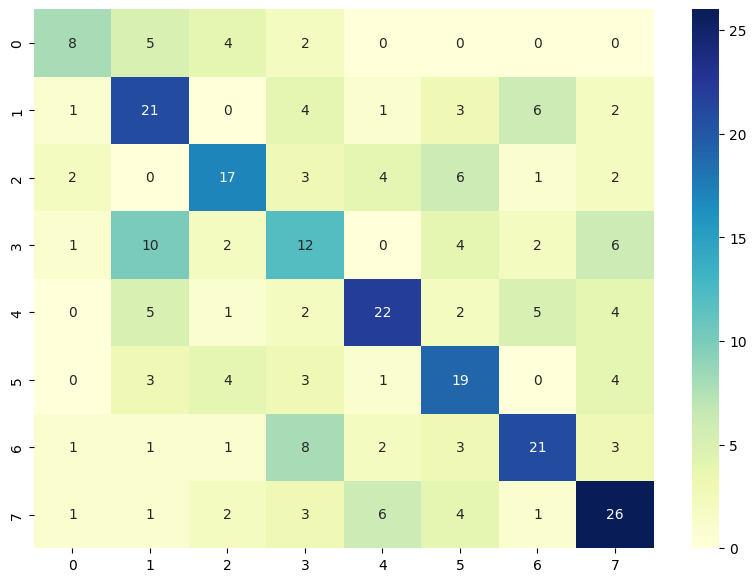

In [38]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(8)], columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.42      0.48        19
           1       0.46      0.55      0.50        38
           2       0.55      0.49      0.52        35
           3       0.32      0.32      0.32        37
           4       0.61      0.54      0.57        41
           5       0.46      0.56      0.51        34
           6       0.58      0.53      0.55        40
           7       0.55      0.59      0.57        44

    accuracy                           0.51       288
   macro avg       0.51      0.50      0.50       288
weighted avg       0.51      0.51      0.51       288



## We achieve an accuracy of 50% from training a 1D CNN on the MFCCs of the audio.